In [ ]:
%%shell
jupyter nbconvert --to html ///content/Tanzania_Water_Wells_Project_9.ipynb

[NbConvertApp] WARNING | pattern '///content/Tanzania_Water_Wells_Project_9.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.

CalledProcessError: ignored

# **Tanzania Water Wells Project** 
**Hazel Cheng**

**Outlines:**

1. Install Spark and load datasets in PySpark
2. Format column datatype, remove withespaces and drop duplicates
3. Remove columns with null values base on pre-defined thresholds
4. Group, aggregate, and create pivot tables
5. Regroup low frequency categories and impute missing numeric values
6. Create visualizations and gather insights

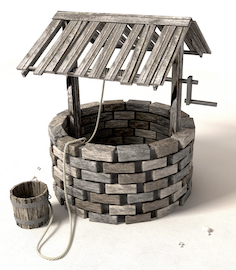

### **Part 1 - Install Spark, download datasets, create final dataframe.**

In [ ]:
# install Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
# install boto3 from python
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 8.8 MB/s 
     |████████████████████████████████| 8.9 MB 39.5 MB/s 
     |████████████████████████████████| 79 kB 4.7 MB/s 
     |████████████████████████████████| 138 kB 46.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# import libraries and tools
import boto3
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"
import findspark
findspark.init()
from google.colab import files
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
from matplotlib import image
import pandas as pd
import seaborn as sns

In [ ]:

s3_client = boto3.client(
    "s3",
    aws_access_key_id='ID',
    aws_secret_access_key='Key',
)

response = s3_client.get_object(Bucket = "tanzaniawellsproject", Key= "features.csv")
feature = pd.read_csv(response['Body'])


s3_client = boto3.client(
    "s3",
    aws_access_key_id='ID',
    aws_secret_access_key='Key',
)

response = s3_client.get_object(Bucket = "tanzaniawellsproject", Key= "labels.csv")
label = pd.read_csv(response['Body'])



In [ ]:
feature_title_explaination = {
'amount_tsh' : 'Total static head (amount water available to waterpoint)',
'date_recorded' : 'The date the row was entered',
'funder' : 'Who funded the well',
'gps_height' : 'Altitude of the well',
'installer' : 'Organization that installed the well',
'longitude' : 'GPS coordinate',
'latitude' : 'GPS coordinate',
'wpt_name' : 'Name of the waterpoint if there is one',
'num_private' : 'NA',
'basin' : 'Geographic water basin',
'subvillage' : 'Geographic location',
'region' : 'Geographic location',
'region_code' : 'Geographic location (coded)',
'district_code' : 'Geographic location (coded)',
'lga' : 'Geographic location',
'ward' : 'Geographic location',
'population' : 'Population around the well',
'public_meeting' : 'True/False',
'recorded_by' : 'Group entering this row of data',
'scheme_management' : 'Who operates the waterpoint',
'scheme_name' : 'Who operates the waterpoint',
'permit' : 'If the waterpoint is permitted',
'construction_year' : 'Year the waterpoint was constructed',
'extraction_type' : 'The kind of extraction the waterpoint uses',
'extraction_type_group' : 'The kind of extraction the waterpoint uses',
'extraction_type_class' : 'The kind of extraction the waterpoint uses',
'management' : 'How the waterpoint is managed',
'management_group' : 'How the waterpoint is managed',
'payment' : 'What the water costs',
'payment_type' : 'What the water costs',
'water_quality' : 'The quality of the water',
'quality_group' : 'The quality of the water',
'quantity' : 'The quantity of water',
'quantity_group' : 'The quantity of water',
'source' : 'The source of the water',
'source_type' : 'The source of the water',
'source_class' : 'The source of the water',
'waterpoint_type' : 'The kind of waterpoint',
'waterpoint_type_group' : 'The kind of waterpoint'
}


label_title_explaination = {
'functional' : 'the waterpoint is operational and there are no repairs needed',
'functional needs repair' : 'the waterpoint is operational, but needs repairs',
'non functional' : 'the waterpoint is not operational'
}

# print(feature_title_explaination)
# print(label_title_explaination)

In [ ]:
sc = SparkSession.builder.master('local[*]').getOrCreate()
!wget https://tanzaniawellsproject.s3.amazonaws.com/features.csv # features.csv
!wget https://tanzaniawellsproject.s3.amazonaws.com/labels.csv # labels.csv
feature = sc.read.csv('features.csv', inferSchema = True, header = True)
label = sc.read.csv('labels.csv', inferSchema = True, header = True)

# feature.show()
# label.show()

--2022-06-27 01:05:27--  https://tanzaniawellsproject.s3.amazonaws.com/features.csv
Resolving tanzaniawellsproject.s3.amazonaws.com (tanzaniawellsproject.s3.amazonaws.com)... 52.216.250.228
Connecting to tanzaniawellsproject.s3.amazonaws.com (tanzaniawellsproject.s3.amazonaws.com)|52.216.250.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20069199 (19M) [text/csv]
Saving to: ‘features.csv’

features.csv        100%[===================>]  19.14M  23.2MB/s    in 0.8s    

2022-06-27 01:05:28 (23.2 MB/s) - ‘features.csv’ saved [20069199/20069199]

--2022-06-27 01:05:28--  https://tanzaniawellsproject.s3.amazonaws.com/labels.csv
Resolving tanzaniawellsproject.s3.amazonaws.com (tanzaniawellsproject.s3.amazonaws.com)... 52.216.186.227
Connecting to tanzaniawellsproject.s3.amazonaws.com (tanzaniawellsproject.s3.amazonaws.com)|52.216.186.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148327 (1.1M) [text/csv]
Saving to: ‘labels.csv’


In [ ]:
# join 'feature' dateset with 'label' dataset using 'id' as the primary key

data = feature.join(label, on = 'id', how = 'leftouter')
# data.show(10)
# print(data.printSchema())

### **Part 2 - Change column type, drop duplicated rows, remove whitespacs.**

In [ ]:
# For [region code] and [district code], they are supposed to be categorical data instead of numerical in order to function properly in machine learning.
# So, we need to change the data type from 'integer' to 'string' by using withColumn() function.

data = data.withColumn('region_code', col('region_code').cast(StringType())).withColumn('district_code', col('district_code').cast(StringType()))
# data.printSchema()


In [ ]:
# It's always better to drop unnecessary or redundant rows before processing data for official use.
# We can distinguish duplicate rows by the dataset's primary key, which is 'id' in this data file.

data = data.dropDuplicates(['id'])
data.count()

# Compare with the result of count, we noticed that this number remains same as before and after we implement the transformation.

59400

In [ ]:
# You can only remove leading or trailing spaces from character(string) columns.

# Step 1: identify string columns
# use 'dtypes' property to extract the column names and their data types.
# select columns which have data type as string

str_cols = [item[0] for item in data.dtypes if item[1].startswith('string')]
# print(str_cols)

# Step 2: remove whitespaces in each of these columns by 'trim' function
for cols in str_cols:
  data = data.withColumn(cols, trim(data[cols]))
  

### **Part 3 - Remove columns with null values more than a threshold.**

In [ ]:
# remove null
# Based on the schema, we found columns with timestamp or boolean type are 'date_recorded', 'public_meeting', and 'permit'.

nullcount = data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting', 'permit'}])
# nullcount.show()

# This resulted table gives each row with its column name and number of nulls contained.
# Then, we noticed that the column 'scheme_name' has a significantly large number of null values, take up a half amount of values in that column.
# Instead of manually going though each value to decide whether to keep or drop the column, we can set a threshold to automatically make this decision.
# We set the thresold by calculating the null percentage.
agg_null = data.select([(count(when(isnan(c) | col(c).isNull(), c))/data.count()).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting', 'permit'}]).collect()


In [ ]:
# convert the data structure to dictionary

agg_dict_list = [i.asDict() for i in agg_null]
agg_dict = agg_dict_list[0]

# print(agg_dict_list)
# print(agg_dict)

In [ ]:
# set the null percent threshold to 0.4

col_null = list({i for i in agg_dict if agg_dict[i] > 0.4})
print(col_null)


['scheme_name']


### **Part 4 - Group, aggregate, create pivot table.**

In [ ]:
# group by the column 'recorded_by'
data.groupBy('recorded_by').count().show()

# There is only one category of 'recorded_by', and the number of this category is 59400.

+--------------------+-----+
|         recorded_by|count|
+--------------------+-----+
|GeoData Consultan...|59400|
+--------------------+-----+



In [ ]:
# group by the column 'water_quality'

data.groupBy('water_quality').count().orderBy('count', ascending = False).show()

# Quite a informative partition after grouping.

+------------------+-----+
|     water_quality|count|
+------------------+-----+
|              soft|50818|
|             salty| 4856|
|           unknown| 1876|
|             milky|  804|
|          coloured|  490|
|   salty abandoned|  339|
|          fluoride|  200|
|fluoride abandoned|   17|
+------------------+-----+



In [ ]:
# since 'recorded_by' column is not very imformative, to speed up our data processing, we choose to drop this column.

data = data.drop('recorded_by')


In [ ]:
# Now, let's create a pivot table that grouped by the status of the well in each region and calculate the sum of total amount of water in the wells.

# As normal dataframe, less structed, less efficient
data.groupBy('region','status_group').sum('amount_tsh').limit(10).show()

# As pivot table, more intuitive, easy to coordinate targets
# rows are 3 types of status; columns are defined for each region name; values shown in middle space are the total amount of water in the wells for each region and each status
data.groupBy('status_group').pivot('region').sum('amount_tsh').limit(10).show()


+-------------+--------------------+------------------+
|       region|        status_group|   sum(amount_tsh)|
+-------------+--------------------+------------------+
|      Manyara|          functional|          312745.0|
|       Iringa|      non functional|          752295.0|
|        Pwani|          functional|         1567765.0|
|Dar es Salaam|      non functional|            9374.0|
|       Ruvuma|      non functional|          414669.0|
|       Mwanza|          functional|           33550.0|
|        Tanga|functional needs ...|            4310.0|
|      Singida|          functional|          863415.0|
|  Kilimanjaro|      non functional|248454.40000000002|
|        Mbeya|      non functional|               0.0|
+-------------+--------------------+------------------+

+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+-----

### **Part 5 - Convert categories with low frequency to Others, impute missing values.**

In [ ]:
# In character columns, categories which are lowly represented are not informative, and can be grouped together as a single category.
# In numeric columns, missing values should be imputed or given a default value. 
# Rather than giving a default value of 0 or the mean of the full column, it's better to give the average value over some grouping.

# Step 1: filter out all category(string) columns, remember this is stored as 'str_cols' that we processed before.
print(str_cols)



['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [ ]:
# Within each column, you want to convert categories which occured less than, for example, 1000 times to a category called 'Others.
# This will reduce the cardinality of columns, which have high number of unique categories but occuring less frequently.
# This will help you in creating better visualizations and reduce the number of one hot encoding required in machine learning algorithums.

# Try for first two character columns

# Step 1: Print the current categories and their frequency in descending order
for column in str_cols[:2]:
  print(data.groupBy(column).count().orderBy('count', ascending = False).limit(10).show())

# store this pair of categories and frequencies in a variable.
  values_cat = data.groupBy(column).count().collect()

# Iterate over each pair and store the categories' name.
# x[0] is categories' name, and x[1] is its frequency.
# If its frequency is below 1000, in a new variable called 'lessthan'.
  less_than = [x[0] for x in values_cat if x[1] < 1000]

  data = data.withColumn(column, when(col(column).isin(less_than), 'Others').otherwise(col(column)))
  data.groupBy(column).count().orderBy('count', ascending = False).limit(10).show()


# Note: The threshold of 1000 is arbituary, and you should change it as you needs (eg. change the specific number to rates.)
  

+--------------------+-----+
|              funder|count|
+--------------------+-----+
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|              Unicef| 1057|
|               Tasaf|  877|
+--------------------+-----+

None
+--------------------+-----+
|              funder|count|
+--------------------+-----+
|              Others|35052|
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|              Unicef| 1057|
+--------------------+-----+

+----------+-----+
| installer|count|
+----------+-----+
|       DWE|17402|
|      null| 3655|
|Government| 1825|
|       RWE| 1206|
|     Commu| 1060|
|    DANIDA| 1050|
|      KKK

In [ ]:
# This column records population around each well.
# Let's print out the frequency of each population recorded, and order by the population rather than the frequency.

data.groupBy('population').count().orderBy('population').limit(10).show()


+----------+-----+
|population|count|
+----------+-----+
|         0|21381|
|         1| 7025|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
+----------+-----+



In [ ]:
# From the table we get, there are about 28000 wells which have population 0 or 1.
# This is an error and should be fixed.
# One way to fix is to replace this population by the average population in a district where the well is located.

# Step 1: Impute this population values with null.
data = data.withColumn('population', when(col('population') < 2, lit(None)).otherwise(col('population')))

# Step 2: Partition the data on the column 'district_code'.
w = Window.partitionBy(data['district_code'])

# Step 3: Replace all the null values in the column with the average population over the partition window
data = data.withColumn('population', when(col('population').isNull(), avg(data['population']).over(w)).otherwise(col('population')))

# Step 4: Round the imputed population values using 'ceil()' function.
data = data.withColumn('population', ceil(data['population']))

# Step 5: Print out the frequency of each population recorded and ordered by the population again.
data.groupBy('population').count().orderBy('population').limit(10).show()

# Note: Population of 0 and 1 are not exist anymore, although there are 35 null values as some district do not have population recorded.

+----------+-----+
|population|count|
+----------+-----+
|      null|   35|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
+----------+-----+



### **Part 6 - Make visualizations.**

In [ ]:
color_status = {'functional': 'green', 'non functional': 'red', 'functional needs repair': 'blue'}

In [ ]:
# Spark does not come with any visualization library, so we have to convert the Spark dataframe to Pandas dataframe before creating visualizations.
# As big data can be extremely large, one trick that can be utilized is to select the required columns for plotting, and then convert this subsetted dataset to panda's dataframe.

# Let's select five columns and convert the subsetted dataframe to Panda's dataframe.
cols = ['status_group', 'payment_type', 'longitude', 'latitude', 'gps_height']
df = data.select(cols).toPandas()


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

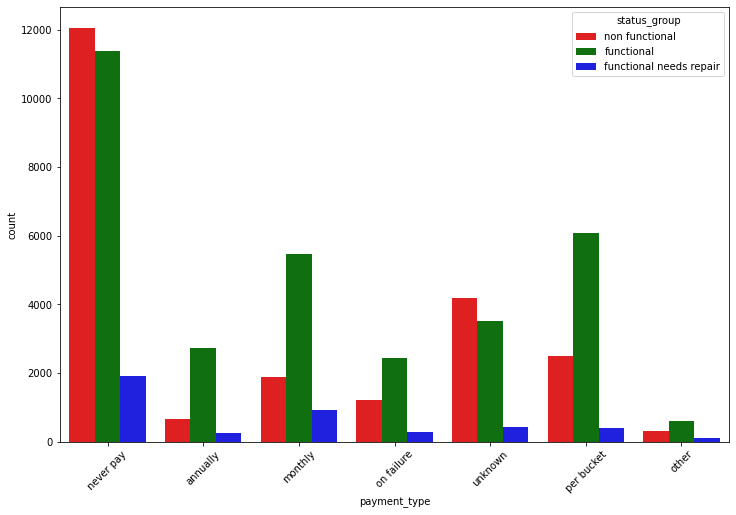

In [ ]:
# Step 1: Make a barplot on number of wells in each payment type and color by status of the wells using 'countplot()' function.
fig, ax = plt.subplots(figsize = (12, 8))
sns.countplot(x = 'payment_type', hue = 'status_group', data = df, ax = ax, palette = color_status)
plt.xticks(rotation = 45)

# Note: Wells that are paid annually, monthly, or per bucket fare better than ones that are never paid.

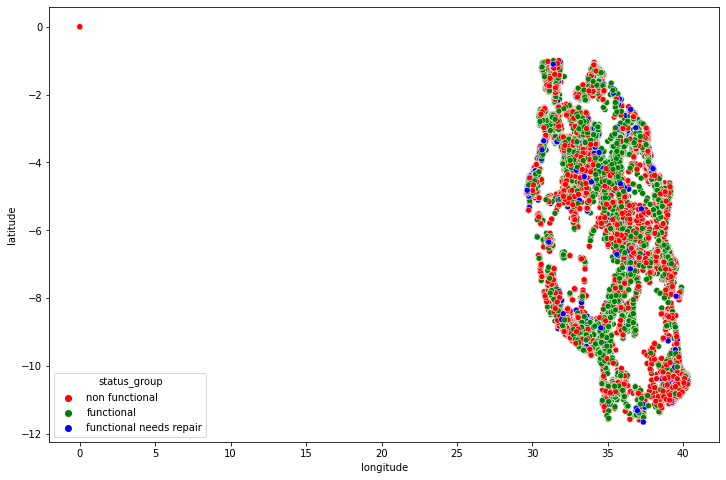

In [ ]:
# Step 2: Plot the latitude and the longtitude of each well as a scatterplot and color by the status using the 'scatterplot()' function.
# This will show you the location of each well and how they are doing.

fig, ax = plt.subplots(figsize = (12, 8))
sns.scatterplot(x = 'longitude', y = 'latitude', data = df, hue = 'status_group', ax = ax, palette = color_status)

# There doesn't seen any pattern here, but you do see an error of longitude and latitude being 0 at the top left cornor.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

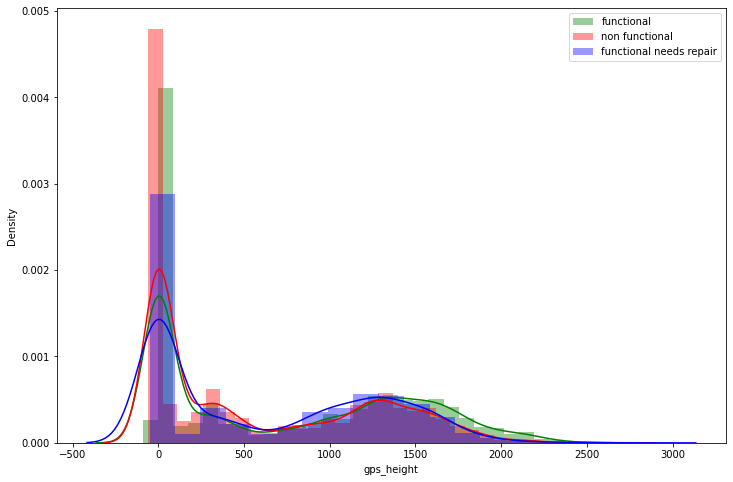

In [ ]:
# Let's create a histogram with kernel density estimates of the column GPS height using the 'displot' function.
# This column tells you the altitude of the well.

# Step 1: seperate the dataframe into 3 subsets, one for each type of status.
row_functional = (df['status_group'] == 'functional')
row_non_functional = (df['status_group'] == 'non functional')
row_repair = (df['status_group'] == 'functional needs repair')

# Step 2: create a displot for each subset using the column GPS height and the same color coding.
col = 'gps_height'
fig, ax = plt.subplots(figsize = (12, 8))
sns.distplot(df[col][row_functional], color = 'green', label = 'functional', ax = ax)
sns.distplot(df[col][row_non_functional], color = 'red', label = 'non functional', ax = ax)
sns.distplot(df[col][row_repair], color = 'blue', label = 'functional needs repair', ax = ax)
plt.legend()

# Note: In general, wells at lower altitude are more functional than wells at higher altitude.
# Additionally, certain wells have negative heights and these should be fixed.

In [ ]:
from google.colab import files
datapd = data.toPandas()
datapd.to_csv('datapd.csv')
#files.download('datapd.csv') 

In [ ]:
client = boto3.client('s3')
client.upload_file(Filename = '/Users/heyuecheng/Documents/datapd.csv', 
                   Bucket = 'tanzaniawellsproject', 
                   Key = 'datapd.csv')

FileNotFoundError: ignored